In [1]:
!pip install kaggle

**Importing the dependencies**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [3]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 145M/149M [00:00<00:00, 177MB/s]
100% 149M/149M [00:00<00:00, 160MB/s]


In [5]:

# convert the zip files into normal
from zipfile import ZipFile

data="/content/brain-tumor-mri-dataset.zip"

with ZipFile(data,"r") as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [6]:
train_dir="/content/Training"
test_dir="/content/Testing"

train_path=[]
train_label=[]

# loop through the all images and labels for sepearte the label and images
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    # added all images into the train_apths
    train_path.append(os.path.join(train_dir,label,image))
    train_label.append(label)

    train_path,train_label=shuffle(train_path,train_label)





# same for tesing data also
test_path=[]
test_label=[]

# loop through the all images and labels for sepearte the label and images
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    # added all images into the train_apths
    test_path.append(os.path.join(test_dir,label,image))
    test_label.append(label)

    test_path,test_label=shuffle(test_path,test_label)





In [7]:
len(train_path)

5712

In [8]:


len(test_path)

1311

In [9]:
train_path[0]

'/content/Training/glioma/Tr-gl_1120.jpg'

In [10]:
type(train_path)

list

**Data Visualization**

[5541, 1791, 789, 1445, 5601, 2949, 1184, 5117, 197, 488]


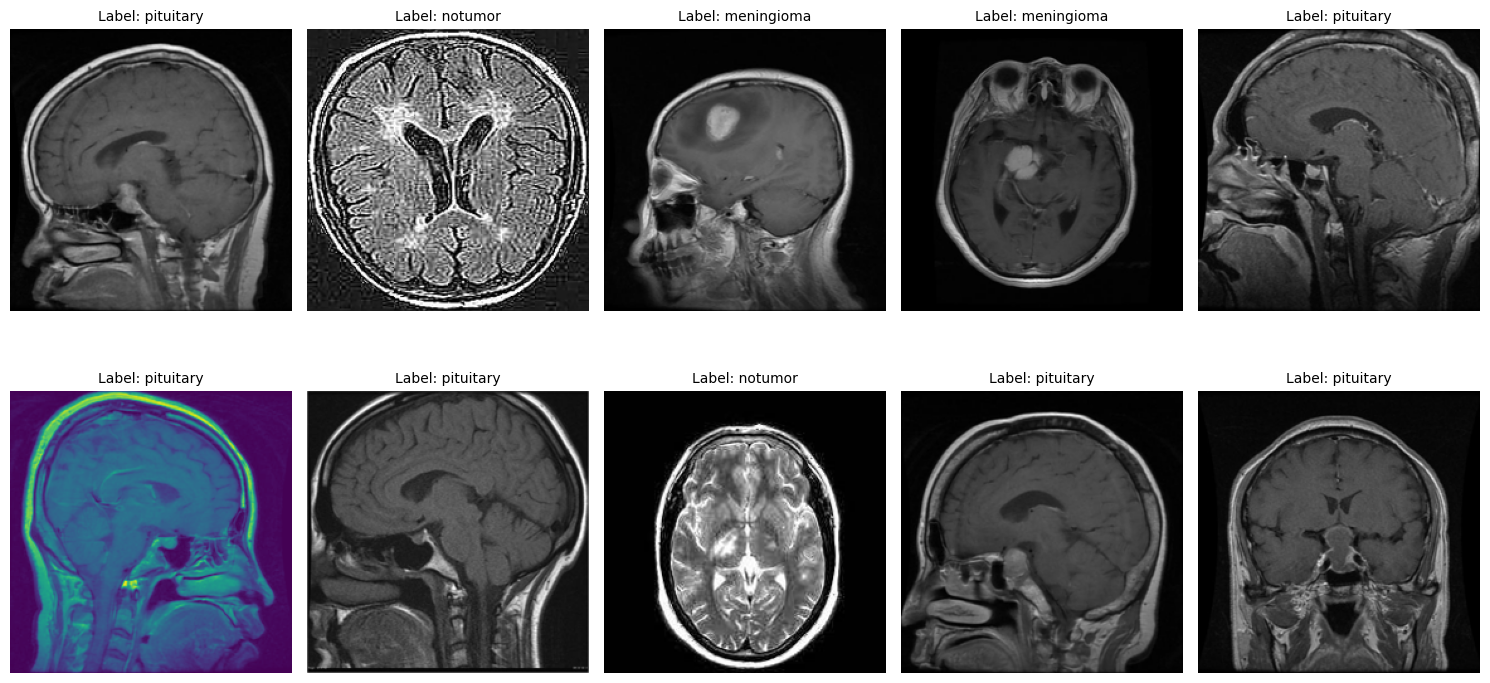

In [11]:
# take random images
import random
import matplotlib.pyplot as plt
random_indices=random.sample(range(len(train_path)),10)
print(random_indices)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes=axes.ravel()

# loop through all random images
for id,idex in enumerate(random_indices):
  img=train_path[idex]
  img=Image.open(img)
  img=img.resize((224,224))

  # Display image
  axes[id].imshow(img)
  axes[id].axis('off')  # Hide axis
    # Display class label in the second row
  axes[id].set_title(f"Label: {train_label[idex]}", fontsize=10)



plt.tight_layout()
plt.show()


In [12]:
import matplotlib
print(matplotlib.__version__)


3.10.0


**Image Preprocessing**

**Model Building VGG16**

In [13]:
from tensorflow.keras.preprocessing import image as keras_image  # Import image correctly

# Data augmentation function for image brightness and contrast
def data_augument(image):
    img = Image.fromarray(np.uint8(image))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))  # Random brightness
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))  # Random contrast
    img = np.array(img) / 255.0  # Normalize pixel values
    return img


# Load images, apply augmentation, and append them to a list
def load_image(paths, image_size=128):
    images = []
    for path in paths:
        img = keras_image.load_img(path, target_size=(image_size, image_size))  # Corrected
        img = keras_image.img_to_array(img)  # Convert image to array
        img = data_augument(img)  # Apply data augmentation
        images.append(img)
    return np.array(images)


# Label encoding function
def label_encoder(labels, train_dir):
    unicode_label = os.listdir(train_dir)  # Get the class labels from the directory
    encoded = [unicode_label.index(label) for label in labels]  # Encode labels
    return np.array(encoded)


  # Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)


# Data generator for batching
def datagen(paths, labels, train_dir, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = load_image(batch_paths)  # Load and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = label_encoder(batch_labels, train_dir)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch


# Define image size
Image_Size = 128
num_of_classes = 4  # Assuming there are 4 classes in the dataset

# Load the VGG16 base model (without top layers) and freeze its weights
base_model = VGG16(input_shape=(Image_Size, Image_Size, 3), include_top=False, weights="imagenet")

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# Create a Sequential model
model = Sequential()
model.add(Input(shape=(Image_Size, Image_Size, 3)))  # Input layer
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(64, activation="relu"))  # Dense layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(num_of_classes, activation="softmax"))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Display model summary
model.summary()


# Parameters
batch_size = 20
steps = int(len(train_path) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_path, train_label, train_dir, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,239,300 (58.13 MB)

 Trainable params: 7,604,036 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.7267 - loss: 0.6793
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.9114 - loss: 0.2526
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9360 - loss: 0.1772
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9529 - loss: 0.1297
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9694 - loss: 0.0855


**Visualiza the plots**

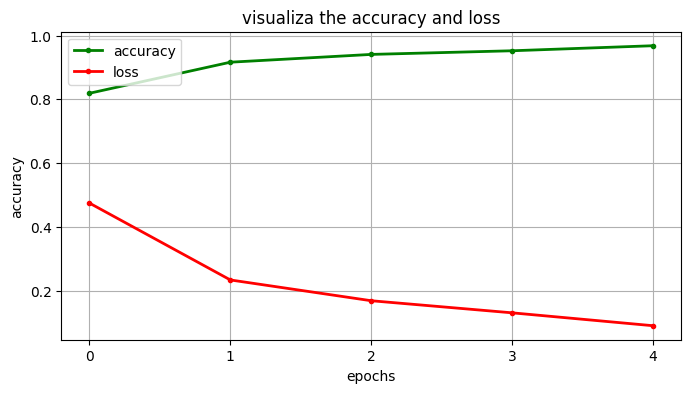

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)

plt.plot(history.history["accuracy"],'.g-', linewidth=2)
plt.plot(history.history["loss"],'.r-', linewidth=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks([x for x in range(epochs)])
plt.title("visualiza the accuracy and loss")
plt.legend(["accuracy","loss"],loc='upper left')
plt.show()


**Classification report**

In [16]:
# 1. Prediction on test data
from sklearn.metrics import classification_report
test_images = load_image(test_path)  # Load and augment test images
test_labels_encoded = label_encoder(test_label,test_dir)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       405
           1       0.94      0.95      0.95       306
           2       0.96      0.95      0.96       300
           3       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [17]:
print(test_label)

['meningioma', 'notumor', 'notumor', 'notumor', 'meningioma', 'pituitary', 'meningioma', 'notumor', 'notumor', 'pituitary', 'pituitary', 'notumor', 'notumor', 'glioma', 'pituitary', 'notumor', 'notumor', 'meningioma', 'notumor', 'glioma', 'meningioma', 'notumor', 'pituitary', 'meningioma', 'notumor', 'pituitary', 'notumor', 'notumor', 'notumor', 'pituitary', 'pituitary', 'glioma', 'meningioma', 'glioma', 'glioma', 'pituitary', 'notumor', 'notumor', 'pituitary', 'meningioma', 'meningioma', 'glioma', 'meningioma', 'glioma', 'meningioma', 'glioma', 'pituitary', 'meningioma', 'glioma', 'notumor', 'glioma', 'meningioma', 'notumor', 'notumor', 'notumor', 'notumor', 'meningioma', 'pituitary', 'glioma', 'meningioma', 'notumor', 'notumor', 'glioma', 'glioma', 'meningioma', 'notumor', 'meningioma', 'pituitary', 'glioma', 'pituitary', 'notumor', 'meningioma', 'notumor', 'glioma', 'pituitary', 'pituitary', 'glioma', 'notumor', 'glioma', 'notumor', 'pituitary', 'pituitary', 'notumor', 'pituitary', 

Confusion Matrix
[[401   1   2   1]
 [  2 292   8   4]
 [  0  15 285   0]
 [  0   3   1 296]]


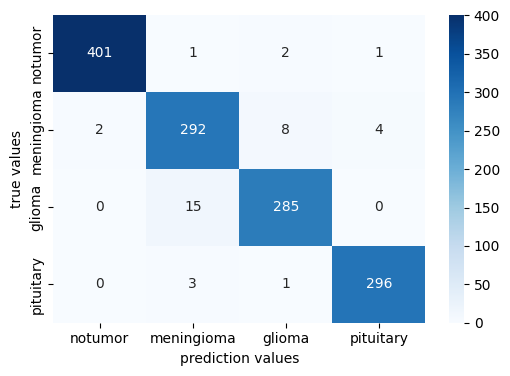

In [18]:
print("Confusion Matrix")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))

print(conf_matrix)
plt.figure(figsize=(6,4))
import seaborn as sns
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel("prediction values")
plt.ylabel("true values")
plt.show()

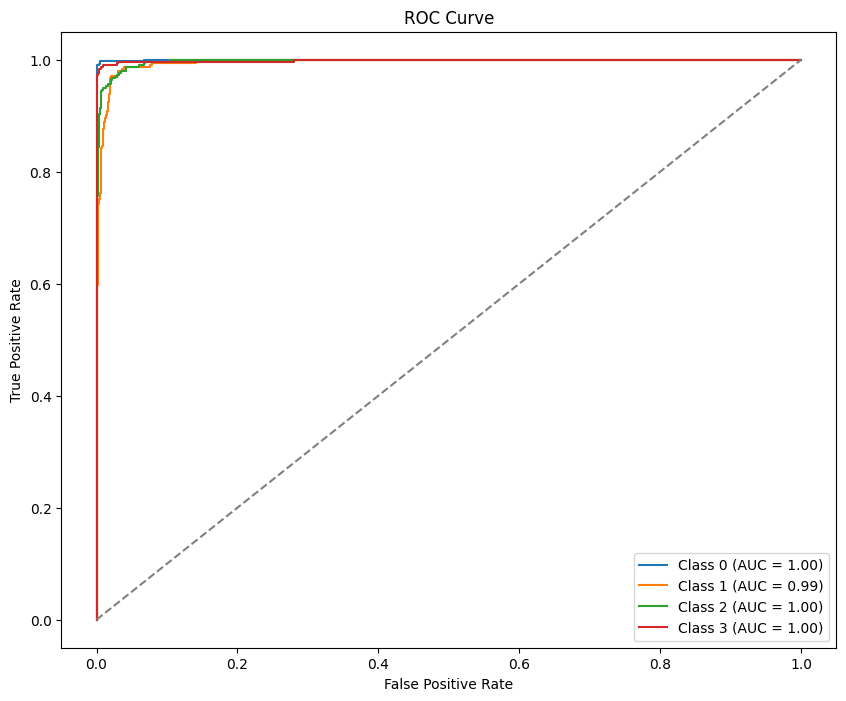

In [19]:
# Roc Curve Plot
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

**Predictive System for Mri Image**

In [20]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))
# Ex



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


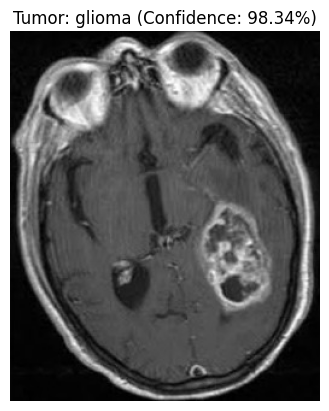

In [21]:
image_path="/content/Testing/meningioma/Te-meTr_0001.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


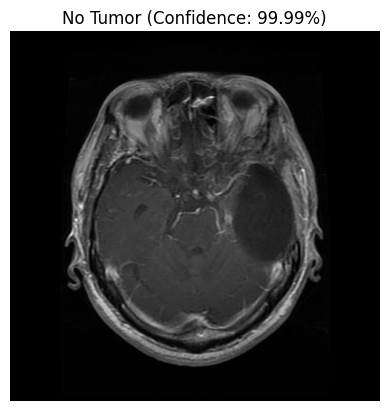

In [22]:
# Example usage
image_path = '/content/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [24]:
# Save the entire model
model.save('my_model.keras')